# Lab Four: Multi-Layer Perceptron

Ephraim Sun (7324)
Jadon Swearingen (5324)
Adeeb Abdul Taher (7324)

Lab Assignment Four: Multi-Layer Perceptron 
In this lab, you will compare the performance of multi-layer perceptron programmed  via your own various implementations. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. This lab project is slightly different from other reports in that you will be asked to complete more specific items.

Dataset Selection

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0Links to an external site.

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks to an external site. 

The classification task you will be performing is to predict, for each tract, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

Grading Rubric

### Load, Split, and Balance (1.5 points total)
[.5 points] 
- (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. 
- (2) Remove any observations that having missing data. 
- (3) Encode any string data as integers for now. 
- (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data into memory and save it to a pandas data frame
df = pd.read_csv('./acs2017_census_tract_data.csv')

# Remove any observations that have missing data
df.dropna(inplace=True)

# Encode any string data as integers
df = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)
print(df.shape)


/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_97887/2187106979.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


(72718, 37)


The next two requirements will need to be completed together as they might depend on one another:
- [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. 

Should balancing of the dataset be done for both the training and testing set? Explain.

No, it should only be done for training. Generally, we don't want to touch the testing set because adjusting the distribution of classes in the testing set could introduce bias and affect the evaluation of the model's generalization performance.


- [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.
Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 

In [2]:
print(df.columns)

Index(['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')


In [3]:
print(df.dtypes)

TractId               int64
State                 int64
County                int64
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          

In [4]:
print(df.nunique())

TractId             72718
State                  52
County               1954
TotalPop             9771
Men                  5639
Women                5775
Hispanic             1001
White                1001
Black                1001
Native                478
Asian                 773
Pacific               173
VotingAgeCitizen     7352
Income              41774
IncomeErr           19699
IncomePerCap        36838
IncomePerCapErr     11093
Poverty               796
ChildPoverty          954
Professional          865
Service               579
Office                480
Construction          483
Production            503
Drive                 981
Carpool               407
Transit               831
Walk                  556
OtherTransp           283
WorkAtHome            335
MeanCommute           526
Employed             5708
PrivateWork           673
PublicWork            621
SelfEmployed          318
FamilyWork             73
Unemployment          447
dtype: int64


In [5]:
income_ranges = [0, 50000, 100000, float('inf')]
income_labels = ['<50000', '50000-100000', '>100000']

df['IncomeEncoded'] = pd.cut(df['Income'], bins=income_ranges, labels=income_labels)

df_encoded = pd.get_dummies(df['IncomeEncoded'])
df = pd.concat([df, df_encoded], axis=1)


In [6]:
# X = X.dropna()
# y = y.dropna()

In [7]:
# Income is our target column
from sklearn.preprocessing import LabelEncoder

X = df.drop('IncomeEncoded', axis=1)  # Features
y = df['IncomeEncoded']  # Target
le = LabelEncoder()

# Fit the encoder to the target variable and transform it
y = le.fit_transform(y)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training set by quantizing the "ChildPoverty" variable into four classes
X_train['ChildPoverty'] = pd.qcut(X_train['ChildPoverty'], q=4, labels=False)
print(X.dtypes)

# # One-hot encode the target variable
# y_train_encoded = pd.get_dummies(y_train)
# y_test_encoded = pd.get_dummies(y_test)


# # Normalize the continuous numeric feature data
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

TractId               int64
State                 int64
County                int64
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          

In [8]:
# Display the first few rows of the dataset
df.head(5)
# print(df.dtypes)

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,IncomeEncoded,<50000,50000-100000,>100000
0,1001020100,0,0,1845,899,946,2.4,86.3,5.2,0.0,...,881,74.2,21.2,4.5,0.0,4.6,50000-100000,False,True,False
1,1001020200,0,0,2172,1167,1005,1.1,41.6,54.5,0.0,...,852,75.9,15.0,9.0,0.0,3.4,<50000,True,False,False
2,1001020300,0,0,3385,1533,1852,8.0,61.4,26.5,0.6,...,1482,73.3,21.1,4.8,0.7,4.7,<50000,True,False,False
3,1001020400,0,0,4267,2001,2266,9.6,80.3,7.1,0.5,...,1849,75.8,19.7,4.5,0.0,6.1,50000-100000,False,True,False
4,1001020500,0,0,9965,5054,4911,0.9,77.5,16.4,0.0,...,4787,71.4,24.1,4.5,0.0,2.3,50000-100000,False,True,False


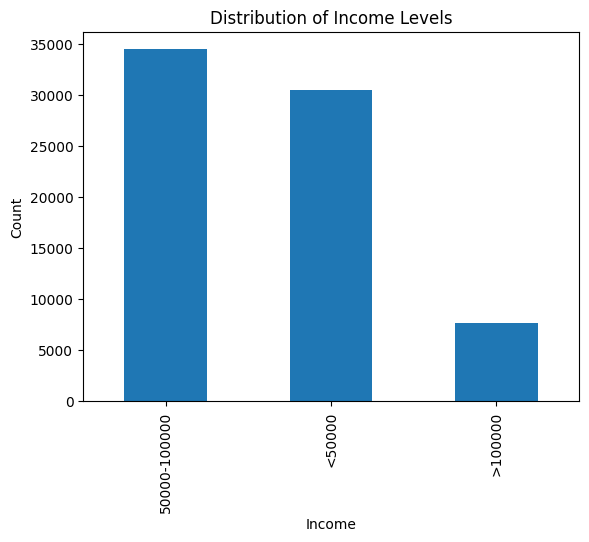

In [9]:
import matplotlib.pyplot as plt

# Create a bar plot of the "Income" variable
df['IncomeEncoded'].value_counts().plot(kind='bar')
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Distribution of Income Levels')
plt.show()


### Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: 
- (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

- [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

- [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

- [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

- [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.



In [10]:
import numpy as np

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(72718, 40)
(72718,)
0 72153750602
[0 1 2]


In [11]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 40)
(58174,)
(14544, 40)
(14544,)


In [12]:
# #Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# #Original Author: Sebastian Raschka


# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        if isinstance(z, pd.DataFrame) or isinstance(z, pd.Series):
            z = z.values
        z = z.astype(float)
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        
        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

In [13]:
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            #had to check for if it is a dataframe bc that breaks the code
            if(self.shuffle and isinstance(X_data, pd.DataFrame)):
                X_data = X_data.reset_index(drop=True)
            # Now you can shuffle
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data.iloc[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
            elif(self.shuffle):
                # if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                #had to check for if it is a dataframe bc that breaks the code
                if isinstance(X_data, pd.DataFrame):
                    A1, Z1, A2, Z2, A3 = self._feedforward(X_data.iloc[idx], self.W1, self.W2)
                else:
                    A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                        self.W1,
                                                        self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= rho_W1 + (self.alpha * rho_W1_prev)
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self
    

In [15]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        epsilon = 1e-7  # small constant
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3 + epsilon) + (1-Y_enc)*np.log(1 - A3 + epsilon))))
        # cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        A1 = A1.astype(np.float64)
        grad1 = V1[1:,:] @ A1.T
        # print(V1[1:,:].shape, A1.T.shape)
        # print(V1[1:,:].dtype, A1.T.dtype)
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        # print("W datatypes:",W1.dtype,W2.dtype)
        # print(grad1.dtype)
        # print(grad2.dtype)
        return grad1, grad2
        
    

In [16]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

In [17]:
# %%time
from sklearn.metrics import accuracy_score

# params = dict(n_hidden=50, 
#               C=0.1, # tradeoff L2 regularizer
#               epochs=50, # iterations
#               eta=0.001,  # learning rate
#               random_state=1)
params = { 'n_hidden':30, 
         'C':0.1, 'epochs':10, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn_better = TLPBetterInitial(**params)

nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
# nn = TLPBetterInitial(**params)

# nn.fit(X_train, y_train, print_progress=50)
yhat = nn_better.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

Epoch: 10/10

Accuracy: 0.4196919691969197


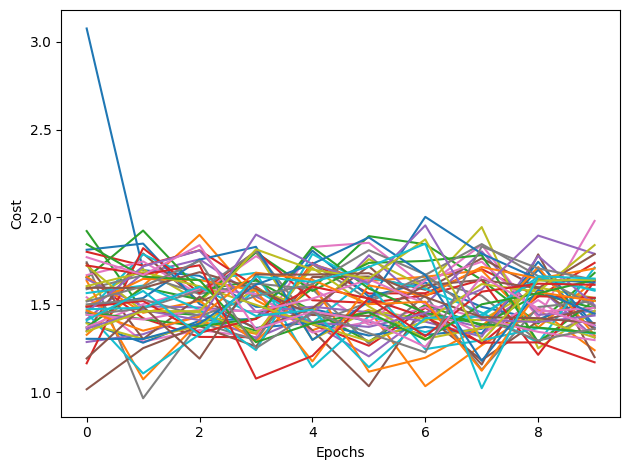

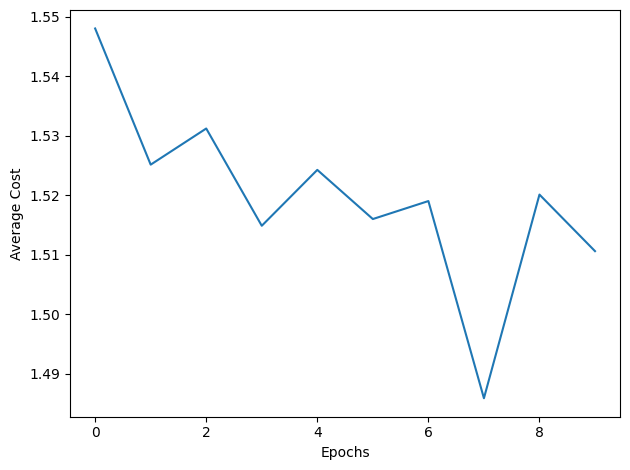

In [18]:
plt.plot(range(len(nn_better.cost_)), nn_better.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# Reshape cost_ into a 2D array where each row is an epoch
cost_per_epoch = np.array(nn_better.cost_).reshape(params['epochs'], -1)
# Take the mean along the rows to get the average cost per epoch
average_cost = cost_per_epoch.mean(axis=1)

plt.plot(range(len(average_cost)), average_cost)
plt.ylabel('Average Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [19]:
#this is ai generated code, not from class:

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create a 2-layer perceptron with 10 nodes in the first layer and 5 in the second
mlp = MLPClassifier(hidden_layer_sizes=(10,5), max_iter=1000)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions
predictions = mlp.predict(X_test)


In [20]:
print(confusion_matrix(y_test,predictions))


[[6895    0    0]
 [6104    0    0]
 [1545    0    0]]


In [21]:
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

           0       0.47      1.00      0.64      6895
           1       1.00      0.00      0.00      6104
           2       1.00      0.00      0.00      1545

    accuracy                           0.47     14544
   macro avg       0.82      0.33      0.21     14544
weighted avg       0.75      0.47      0.30     14544



- [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

Epoch: 10/10

Accuracy: 0.9734598459845984


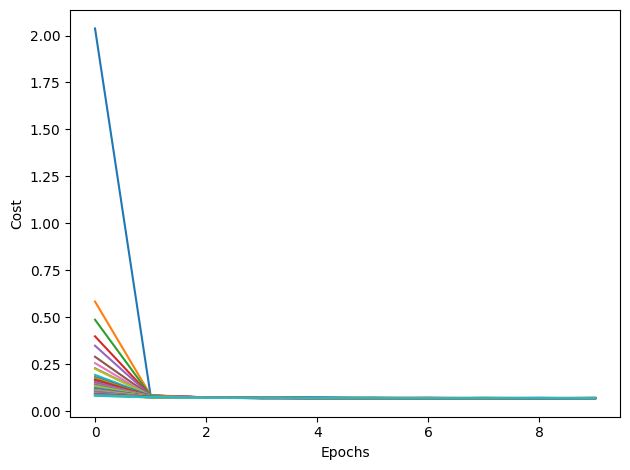

In [22]:
# %%time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on the training set and transform both the training and test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

params = { 'n_hidden':30, 
         'C':0.1, 'epochs':10, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

nn = TLPBetterInitial(**params)
nn.fit(X_train_scaled, y_train, print_progress=1, XY_test=(X_test_scaled, y_test))
yhat = nn.predict(X_test_scaled)
print('Accuracy:',accuracy_score(y_test,yhat))

# nn.fit(X_train_scaled, y_train, print_progress=50)
# yhat = nn.predict(X_test_scaled)
# print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

Epoch: 20/20

Accuracy: 0.8817381738173817


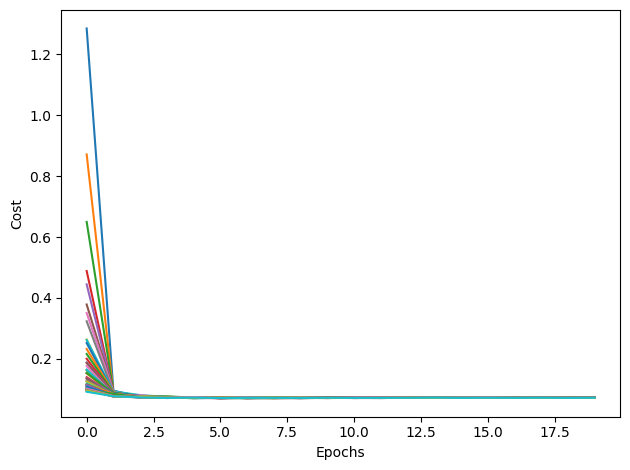

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
df_preprocessed = pd.read_csv('./acs2017_census_tract_data.csv')

# Remove any observations that have missing data
df_preprocessed.dropna(inplace=True)
df_preprocessed = df_preprocessed.drop('County',axis = 1)

df_preprocessed_encoded = pd.get_dummies(df_preprocessed['State'], prefix='State')
df_preprocessed = pd.concat([df_preprocessed, df_preprocessed_encoded], axis=1)
df_preprocessed = df_preprocessed.drop('State', axis=1)
# print(df_preprocessed.dtypes)
# print(df_preprocessed.nunique())
income_ranges = [0, 50000, 100000, float('inf')]
income_labels = ['<50000', '50000-100000', '>100000']

df_preprocessed['IncomeEncoded'] = pd.cut(df_preprocessed['Income'], bins=income_ranges, labels=income_labels)

df_preprocessed_encoded = pd.get_dummies(df_preprocessed['IncomeEncoded'])
df_preprocessed = pd.concat([df_preprocessed, df_preprocessed_encoded], axis=1)


from sklearn.preprocessing import LabelEncoder

X_preprocessed = df_preprocessed.drop('IncomeEncoded', axis=1)  # Features
y_preprocessed = df_preprocessed['IncomeEncoded']  # Target
le = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_preprocessed = le.fit_transform(y_preprocessed)
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_preprocessed, X_test_preprocessed, y_train_preprocessed, y_test_preprocessed = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y_preprocessed)

# Balance the training set by quantizing the "ChildPoverty" variable into four classes
X_train_preprocessed['ChildPoverty'] = pd.qcut(X_train_preprocessed['ChildPoverty'], q=4, labels=False)

# Apply StandardScaler
scaler = StandardScaler()
X_train_preprocessed = scaler.fit_transform(X_train_preprocessed)
X_test_preprocessed = scaler.transform(X_test_preprocessed)


params = { 'n_hidden':30, 
         'C':0.1, 'epochs':20, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}

# nn = TLPBetterInitial(**params)

# nn.fit(X_train_preprocessed, y_train_preprocessed, print_progress=50)
# yhat_preprocessed = nn.predict(X_test_preprocessed)
# print('Accuracy:',accuracy_score(y_test_preprocessed,yhat_preprocessed))

nn = TLPBetterInitial(**params)
nn.fit(X_train_preprocessed, y_train_preprocessed, print_progress=1, XY_test=(X_test_preprocessed, y_test_preprocessed))
yhat = nn.predict(X_test_preprocessed)
print('Accuracy:',accuracy_score(y_test_preprocessed,yhat))


plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()


### Modeling (5 points total)
- [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.

Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

- [1 points] Repeat the previous step, adding support for a fourth layer.

- [1 points] Repeat the previous step, adding support for a fifth layer. 

- [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.